<a href="https://colab.research.google.com/github/traitementimage2024/traitementimage24/blob/main/traitement-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.measure import regionprops


!git clone https://github.com/traitementimage2024/traitementimage24.git
! unzip /content/traitementimage24/traitement-image-20241231T163656Z-001.zip
#notebooks also are not fond of imshow, so I'll use a patch for notebook support.
from google.colab.patches import cv2_imshow


# Chemins des dossiers contenant les images
folder_with_bouchons = "/content/traitement-imageavec_bouchons"
folder_without_bouchons = "/content/traitement-imagesans_bouchons"
folder_deformed = "/content/traitement-image/deforme"
folder_not_deformed = "/content/traitement-image/pas_deforme"
folder_other = "/content/traitement-image/bouteilles_manquante"

# Path to all the bottles
folder_path = "/content/traitement-image/bottleimage"


fatal: destination path 'traitementimage24' already exists and is not an empty directory.
Archive:  /content/traitementimage24/traitement-image-20241231T163656Z-001.zip
replace traitement-image/deforme/image137.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Reconaissance de bouchon

Pour faire la détection de bouchons, on commence par recadrer l'image pour uniquement inclure la partie qui devrait contenir le bouchon.

En suite, l'image est convertie en niveaux de gris, puis binarizée.

À partir de cette image binarizée, on compte le pourcentage de pixels noirs. Celui-ci permet de déterminer si la bouteille est présente, si le bouchon est manquant ou si il est présent.

In [2]:
def CheckCapMissing(image):

    # Put in grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # cv2.imshow("image grayscaled",image_gray)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Determination and crop the region of interest
    x1, y1 = 125, 0  # Left-up corner
    x2, y2 = 250, 63 # Right-down corner

    cropped_image = image_gray[y1:y2, x1:x2]

    #cv2.imshow("Image rognee",cropped_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Binarize the image with threshold in the middle
    seuil = 180  # Valeur de seuil (entre 0 et 255)
    _, image_binaire = cv2.threshold(cropped_image, seuil, 255, cv2.THRESH_BINARY)

    # cv2.imshow("Image binaire",image_binaire)
    cv2_imshow(image_binaire) # make imshow notebook friendly
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    #calculate the percentage
    total_pixels = image_binaire.size
    black_pixels = np.sum(image_binaire == 0)

    # Calcul du pourcentage
    percentage_black = (black_pixels / total_pixels) * 100
    print(percentage_black)

    if percentage_black <= 10:
        return 0    # No bottle
    elif (10 < percentage_black < 35):
        return 1    # Cap missing
    else:
        return 2    # Cap present

---
# Détermination des seuils

Pour référence, le code suivant a servi à établir les seuils de la fonction présentée ci-dessus.

Erreur : Le dossier /content/traitement-imageavec_bouchons n'existe pas.
Erreur : Le dossier /content/traitement-imagesans_bouchons n'existe pas.
Avec bouchons :

Sans bouchons :

Autre :
image133.jpg: 0.00%
image119.jpg: 0.00%
image047.jpg: 0.00%
image069.jpg: 1.07%
image089.jpg: 0.00%
image045.jpg: 0.46%
image116.jpg: 0.90%
image025.jpg: 1.69%
image120.jpg: 0.43%
image122.jpg: 1.21%
image018.jpg: 1.26%
image105.jpg: 0.00%


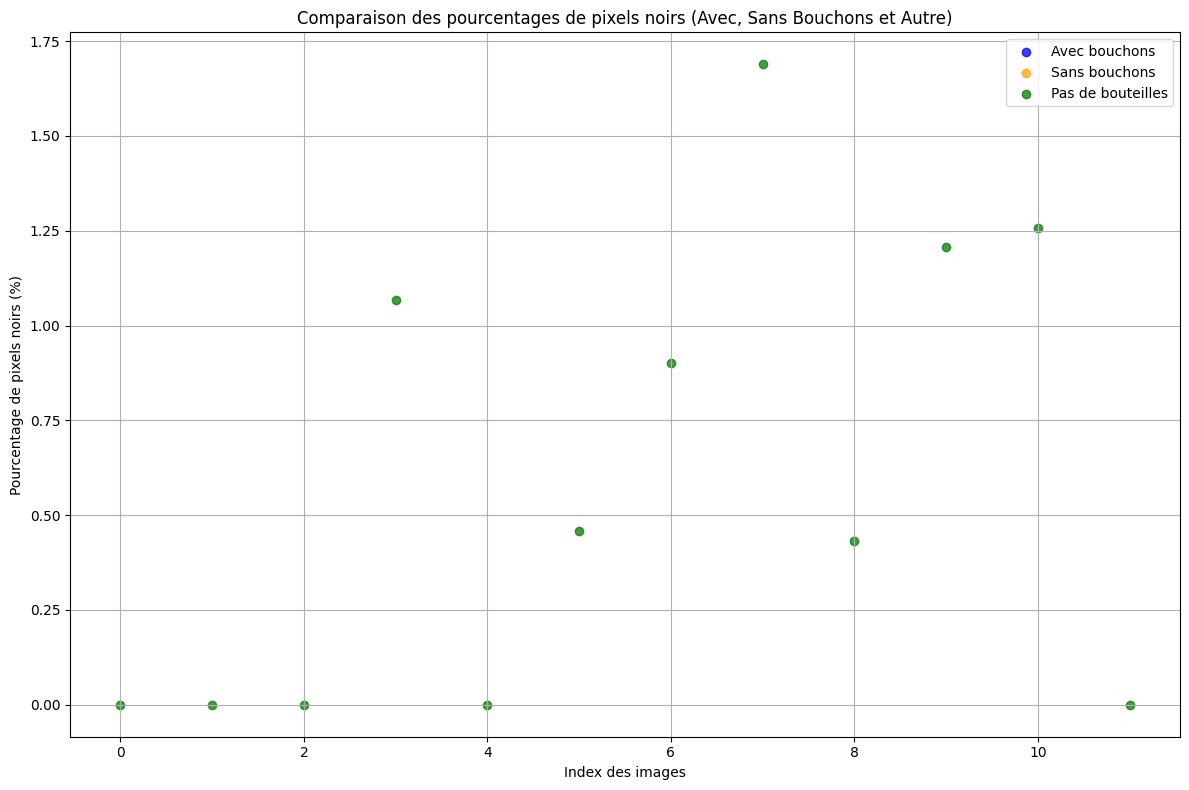

In [3]:

def calculate_black_pixel_percentage(folder_path):
    """
    Calcule le pourcentage de pixels noirs pour toutes les images dans un dossier donné.

    Args:
        folder_path (str): Chemin vers le dossier contenant les images.

    Returns:
        list: Liste des noms des images.
        list: Liste des indices des images.
        list: Liste des pourcentages de pixels noirs.
    """
    if not os.path.exists(folder_path):
        print(f"Erreur : Le dossier {folder_path} n'existe pas.")
        return [], [], []

    # Liste des fichiers dans le dossier
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    if not images:
        print(f"Aucune image trouvée dans le dossier {folder_path}.")
        return [], [], []

    image_names = []
    indices = []
    percentages = []

    for idx, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Charger l'image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erreur : Impossible de charger l'image {image_name}.")
            continue

        # Mettre en niveaux de gris
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Rogner l'image (adapter si nécessaire)
        x1, y1 = 125, 0  # Left-up corner
        x2, y2 = 250, 63  # Right-down corner
        cropped_image = image_gray[y1:y2, x1:x2]
        cropped_image = cv2.medianBlur(cropped_image, 5)

        # Binariser l'image
        seuil = 180
        _, image_binaire = cv2.threshold(cropped_image, seuil, 255, cv2.THRESH_BINARY)

        # Calculer le pourcentage de pixels noirs
        total_pixels = image_binaire.size
        black_pixels = np.sum(image_binaire == 0)
        percentage_black = (black_pixels / total_pixels) * 100

        # Stocker les résultats
        image_names.append(image_name)
        indices.append(idx)
        percentages.append(percentage_black)

    return image_names, indices, percentages


# Calculer les pourcentages pour les trois dossiers
names_with, indices_with, percentages_with = calculate_black_pixel_percentage(folder_with_bouchons)
names_without, indices_without, percentages_without = calculate_black_pixel_percentage(folder_without_bouchons)
names_other, indices_other, percentages_other = calculate_black_pixel_percentage(folder_other)

# Afficher les noms et pourcentages dans la console
print("Avec bouchons :")
for name, percentage in zip(names_with, percentages_with):
    print(f"{name}: {percentage:.2f}%")

print("\nSans bouchons :")
for name, percentage in zip(names_without, percentages_without):
    print(f"{name}: {percentage:.2f}%")

print("\nAutre :")
for name, percentage in zip(names_other, percentages_other):
    print(f"{name}: {percentage:.2f}%")

# Créer les graphiques
plt.figure(figsize=(12, 8))

# Avec bouchons
plt.scatter(indices_with, percentages_with, color='blue', label='Avec bouchons', alpha=0.75)

# Sans bouchons
plt.scatter(indices_without, percentages_without, color='orange', label='Sans bouchons', alpha=0.75)

# Autre
plt.scatter(indices_other, percentages_other, color='green', label='Pas de bouteilles', alpha=0.75)

# Personnalisation du graphique
plt.xlabel('Index des images')
plt.ylabel('Pourcentage de pixels noirs (%)')
plt.title('Comparaison des pourcentages de pixels noirs (Avec, Sans Bouchons et Autre)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Afficher le graphique
plt.show()

#Tests de la fonction CheckCapMissing

Ici, on vient parser les images de bottleimage pour déterminer la performance de la fonction

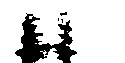

17.46031746031746


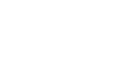

0.0


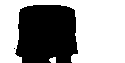

40.507936507936506


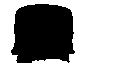

40.29206349206349


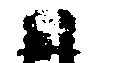

24.469841269841268


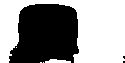

43.25079365079365


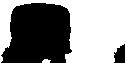

46.32380952380952


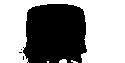

42.12063492063492


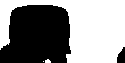

45.44761904761905


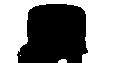

43.66984126984127


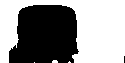

43.46666666666666


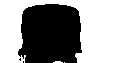

41.63809523809524


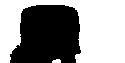

43.212698412698415


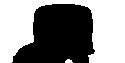

46.26031746031746


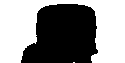

45.7015873015873


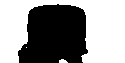

42.98412698412699


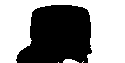

44.076190476190476


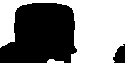

48.787301587301585


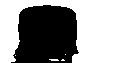

40.95238095238095


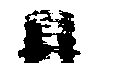

24.31746031746032


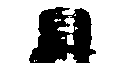

31.86031746031746


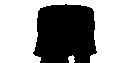

40.58412698412698


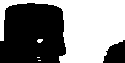

48.96507936507937


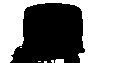

44.82539682539682


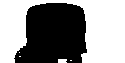

44.736507936507934


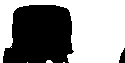

44.08888888888889


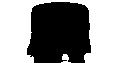

43.073015873015876


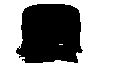

41.98095238095238


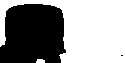

42.857142857142854


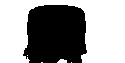

40.9015873015873


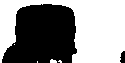

45.25714285714286


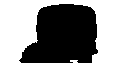

45.6


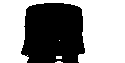

42.20952380952381


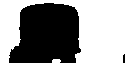

44.66031746031746


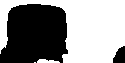

44.63492063492063


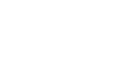

0.0


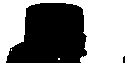

47.94920634920635


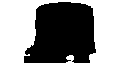

44.96507936507936


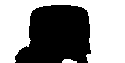

44.22857142857143


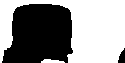

44.27936507936508


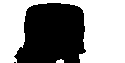

44.457142857142856


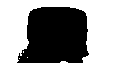

41.993650793650794


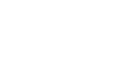

0.0


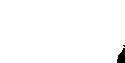

1.1174603174603175


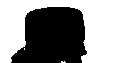

42.47619047619048


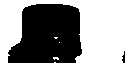

45.38412698412698


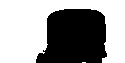

40.076190476190476


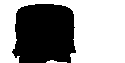

41.473015873015875


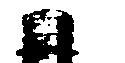

26.107936507936508


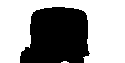

40.52063492063492


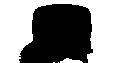

43.84761904761905


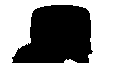

45.53650793650794


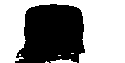

41.803174603174604


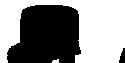

45.180952380952384


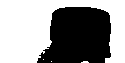

42.425396825396824


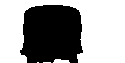

39.885714285714286


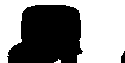

45.29523809523809


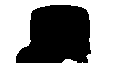

44.06349206349206


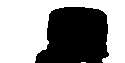

42.285714285714285


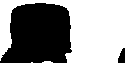

45.092063492063495


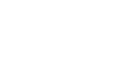

0.0


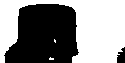

45.955555555555556


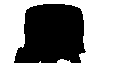

43.55555555555555


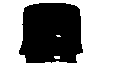

42.24761904761905


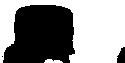

44.457142857142856


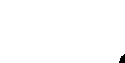

0.48253968253968255


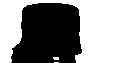

44.82539682539682


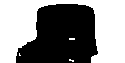

47.07301587301587


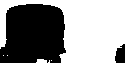

44.25396825396825


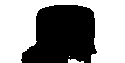

43.53015873015873


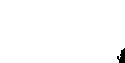

0.9396825396825397


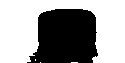

39.31428571428571


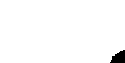

1.7269841269841268


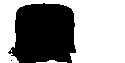

42.31111111111111


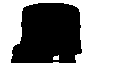

44.888888888888886


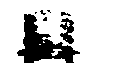

19.961904761904762


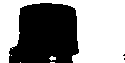

44.076190476190476


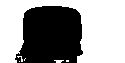

40.86349206349206


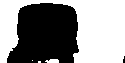

44.49523809523809


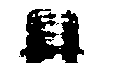

26.93333333333333


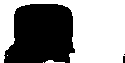

44.08888888888889


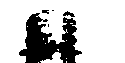

22.526984126984125


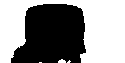

44.60952380952381


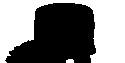

49.65079365079365


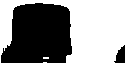

46.05714285714286


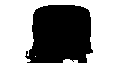

41.35873015873016


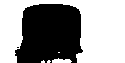

42.18412698412698


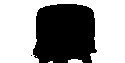

41.523809523809526


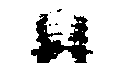

18.704761904761906


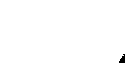

0.4444444444444444


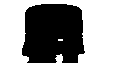

41.079365079365076


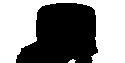

47.27619047619048


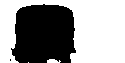

41.269841269841265


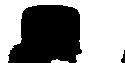

44.1015873015873


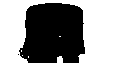

42.43809523809524


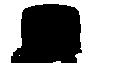

43.61904761904762


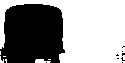

42.06984126984127


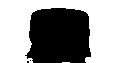

39.7968253968254


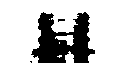

24.52063492063492


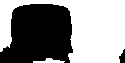

45.01587301587301


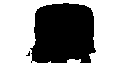

42.69206349206349


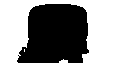

44.05079365079365


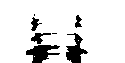

11.466666666666667


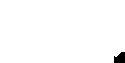

1.2317460317460318


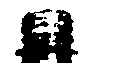

26.158730158730158


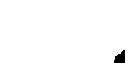

1.2825396825396824


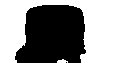

43.06031746031746


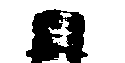

28.19047619047619


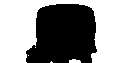

43.7968253968254


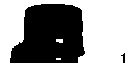

45.3968253968254


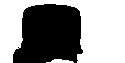

42.66666666666667


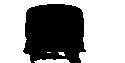

39.453968253968256


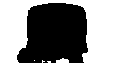

44.19047619047619


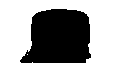

39.42857142857143


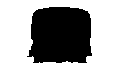

40.08888888888889


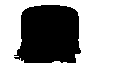

41.16825396825397


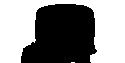

45.663492063492065


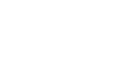

0.0


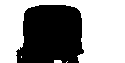

42.32380952380952


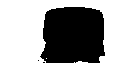

40.86349206349206


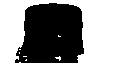

43.39047619047619


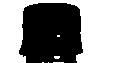

42.53968253968254


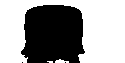

40.36825396825397


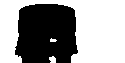

40.87619047619048


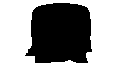

42.66666666666667


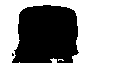

41.37142857142857


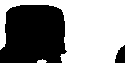

44.266666666666666


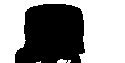

43.50476190476191


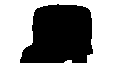

43.91111111111111


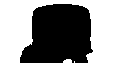

43.885714285714286


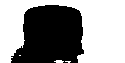

42.47619047619048


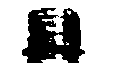

29.473015873015875


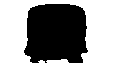

41.20634920634921


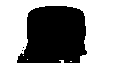

41.2952380952381


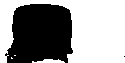

42.13333333333333


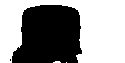

42.7936507936508


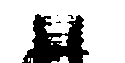

23.61904761904762


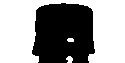

41.2952380952381


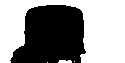

43.50476190476191


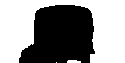

43.84761904761905


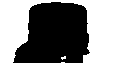

46.679365079365084

--- Résultats de l'analyse ---
image048.jpg: Cap Missing
image133.jpg: No bottle
image035.jpg: Cap Present
image060.jpg: Cap Present
image013.jpg: Cap Missing
image017.jpg: Cap Present
image027.jpg: Cap Present
image050.jpg: Cap Present
image073.jpg: Cap Present
image076.jpg: Cap Present
image134.jpg: Cap Present
image108.jpg: Cap Present
image004.jpg: Cap Present
image130.jpg: Cap Present
image099.jpg: Cap Present
image055.jpg: Cap Present
image098.jpg: Cap Present
image024.jpg: Cap Present
image125.jpg: Cap Present
image086.jpg: Cap Missing
image083.jpg: Cap Missing
image084.jpg: Cap Present
image117.jpg: Cap Present
image071.jpg: Cap Present
image111.jpg: Cap Present
image059.jpg: Cap Present
image091.jpg: Cap Present
image053.jpg: Cap Present
image014.jpg: Cap Present
image132.jpg: Cap Present
image074.jpg: Cap Present
image082.jpg: Cap Present
image101.jpg: Cap Present
image038.jpg: Cap Present
image003.jpg: Cap Present
image119.jpg: No bottle
image097.jpg: Cap

In [4]:
def analyze_images_in_folder(folder_path):
    # Liste pour stocker les résultats
    results = []

    # Parcourir tous les fichiers dans le dossier
    for filename in os.listdir(folder_path):
        # Obtenir le chemin complet de l'image
        file_path = os.path.join(folder_path, filename)

        # Vérifier que le fichier est une image
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # Charger l'image
            image = cv2.imread(file_path)

            # Vérifier si le fichier a été chargé correctement
            if image is None:
                print(f"Impossible de charger le fichier : {file_path}")
                continue

            # Utiliser la fonction CheckCapMissing
            has_cap = CheckCapMissing(image)

            # Ajouter le résultat à la liste
            if has_cap == 0:
                results.append((filename, "No bottle"))
            elif has_cap == 1:
                results.append((filename, "Cap Missing"))
            else:
                results.append((filename, "Cap Present"))

            # Ajouter le résultat à la liste
            if has_cap == 0:
                label = "No bottle"
            elif has_cap == 1:
                label = "Cap Missing"
            else:
                label = "Cap Present"

            cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            #cv2.imshow("Image Analysis", image)

            # I supress the following two lines for easier notebook handling, they simply show the image again.
            # cv2_imshow(image)
            # cv2.waitKey(500)  # Pause pour 500ms (modifiez si besoin)

    # Fermer toutes les fenêtres d'affichage
    cv2.destroyAllWindows()

    # Afficher les résultats finaux
    print("\n--- Résultats de l'analyse ---")
    for filename, result in results:
        print(f"{filename}: {result}")

# Exemple d'utilisation
analyze_images_in_folder(folder_path)

---

# Reconaissance de déformation




In [5]:
def check_if_deformed(image):

    x1, y1 = 100, 190  # Left-up corner
    x2, y2 = 260, 280  # Right-down corner

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Extract the red channel
    imred = cropped_image[:, :, 2]

    # Threshold the red channel to create a binary image
    _, labelbinred = cv2.threshold(imred, 177, 255, cv2.THRESH_BINARY)

    # Calculate the percentage of black pixels
    black_pixels = np.sum(labelbinred == 0)
    total_pixels = labelbinred.size
    percentage = 100 * (black_pixels / total_pixels)

    if percentage > 80:
        # Convert to grayscale and binarize
        mask = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        _, labelbingrayscaled = cv2.threshold(mask, 80, 255, cv2.THRESH_BINARY)

        # Define a structure for 4-connectivity
        structure = np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]])

        labeled_array, num_features = label(labelbingrayscaled, structure=structure)

    else:
        # Define a structure for 4-connectivity
        structure = np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]])

        labeled_array, num_features = label(labelbinred, structure=structure)

    # Extract bounding boxes and calculate the largest area
    properties = regionprops(labeled_array)

    max_area = 0
    aspect_ratio = 0
    circularity = 0
    solidity = 0
    excentricity = 0
    equivalent_diameter = 0

    for prop in properties:
        min_row, min_col, max_row, max_col = prop.bbox
        width = max_col - min_col
        height = max_row - min_row
        area = width * height

        if area > max_area:
            max_area = area
            aspect_ratio = width / height
            perimeter = prop.perimeter if prop.perimeter > 0 else 1  # Avoid division by zero
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            solidity = prop.solidity
            excentricity = prop.eccentricity
            equivalent_diameter = prop.equivalent_diameter

    average_score = (max_area + aspect_ratio + circularity + solidity + excentricity + equivalent_diameter) / 6

    # Determine if the bottle is deformed
    has_label = percentage <= 80
    is_deformed = average_score > 1000 and average_score < 1744

    return is_deformed and has_label

def list_deformed_images(folder_path):
    deformed_images = []

    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if filepath.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
            image = cv2.imread(filepath)
            if check_if_deformed(image):
                deformed_images.append(filename)

    return deformed_images

# List deformed images
deformed_images = list_deformed_images(folder_path)
print("Images déformées avec étiquette :")
for img in deformed_images:
    print(img)

Images déformées avec étiquette :
image039.jpg
image137.jpg
image061.jpg
image136.jpg
image052.jpg
image062.jpg
image049.jpg
image006.jpg
image077.jpg
image032.jpg
image040.jpg


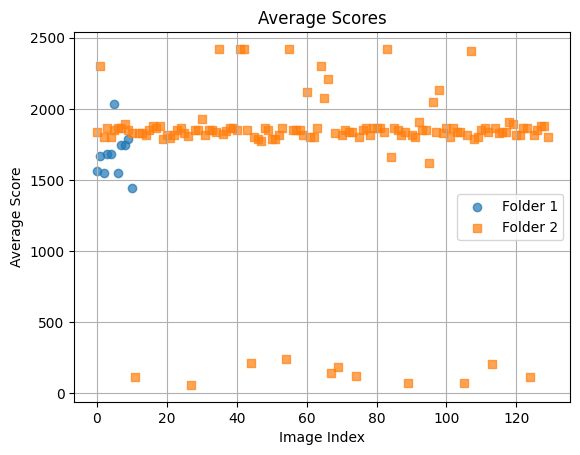

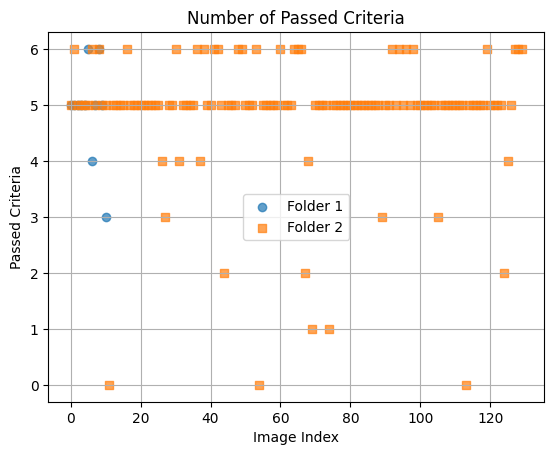

In [6]:

def calculate_properties(image):
    x1, y1 = 100, 190  # Left-up corner
    x2, y2 = 260, 280  # Right-down corner

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Extract the red channel
    imred = cropped_image[:, :, 2]

    # Threshold the red channel to create a binary image
    _, labelbinred = cv2.threshold(imred, 177, 255, cv2.THRESH_BINARY)

    # Calculate the percentage of black pixels
    black_pixels = np.sum(labelbinred == 0)
    total_pixels = labelbinred.size
    percentage = 100 * (black_pixels / total_pixels)

    if percentage > 80:
        # Convert to grayscale and binarize
        mask = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        _, labelbingrayscaled = cv2.threshold(mask, 80, 255, cv2.THRESH_BINARY)

        # Define a structure for 4-connectivity
        structure = np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]])

        labeled_array, num_features = label(labelbingrayscaled, structure=structure)

    else:
        # Define a structure for 4-connectivity
        structure = np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]])

        labeled_array, num_features = label(labelbinred, structure=structure)

    # Extract properties from components
    properties = regionprops(labeled_array)

    max_area = 0
    aspect_ratio = 0
    circularity = 0
    solidity = 0
    excentricity = 0
    equivalent_diameter = 0

    for prop in properties:
        min_row, min_col, max_row, max_col = prop.bbox
        width = max_col - min_col
        height = max_row - min_row
        area = width * height

        if area > max_area:
            max_area = area
            aspect_ratio = width / height
            perimeter = prop.perimeter if prop.perimeter > 0 else 1  # Avoid division by zero
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            solidity = prop.solidity
            excentricity = prop.eccentricity
            equivalent_diameter = prop.equivalent_diameter

    average_score = (max_area + aspect_ratio + circularity + solidity + excentricity + equivalent_diameter) / 6

    passed_criteria = sum([
        max_area > 9000,
        aspect_ratio > 1.1,
        circularity > 0.3,
        solidity > 0.8,
        excentricity < 0.9,
        equivalent_diameter > 50
    ])

    return max_area, aspect_ratio, circularity, solidity, excentricity, equivalent_diameter, average_score, passed_criteria

def process_and_plot(folder1, folder2):
    folder1_properties = []
    folder2_properties = []

    # Process images in folder1
    for filename in os.listdir(folder1):
        filepath = os.path.join(folder1, filename)
        if filepath.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
            image = cv2.imread(filepath)
            folder1_properties.append(calculate_properties(image))

    # Process images in folder2
    for filename in os.listdir(folder2):
        filepath = os.path.join(folder2, filename)
        if filepath.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
            image = cv2.imread(filepath)
            folder2_properties.append(calculate_properties(image))

    # Separate properties for plotting
    folder1_areas, folder1_aspects, folder1_circularities, folder1_solidities, folder1_excentricities, folder1_diameters, folder1_scores, folder1_criteria = zip(*folder1_properties)
    folder2_areas, folder2_aspects, folder2_circularities, folder2_solidities, folder2_excentricities, folder2_diameters, folder2_scores, folder2_criteria = zip(*folder2_properties)

    # Plot each property in separate windows

    # Average Scores
    plt.figure()
    plt.scatter(range(len(folder1_scores)), folder1_scores, label="Folder 1", marker='o', alpha=0.7)
    plt.scatter(range(len(folder2_scores)), folder2_scores, label="Folder 2", marker='s', alpha=0.7)
    plt.title("Average Scores")
    plt.xlabel("Image Index")
    plt.ylabel("Average Score")
    plt.legend()
    plt.grid()
    plt.show()

    # Passed Criteria
    plt.figure()
    plt.scatter(range(len(folder1_criteria)), folder1_criteria, label="Folder 1", marker='o', alpha=0.7)
    plt.scatter(range(len(folder2_criteria)), folder2_criteria, label="Folder 2", marker='s', alpha=0.7)
    plt.title("Number of Passed Criteria")
    plt.xlabel("Image Index")
    plt.ylabel("Passed Criteria")
    plt.legend()
    plt.grid()
    plt.show()

# Run the function
process_and_plot(folder_deformed, folder_not_deformed)